# SNPE & RF

learning receptive field parameters from inputs (white-noise videos) and outputs (spike trains) of linear-nonlinear neuron models with parameterized linear filters

In [1]:
%%capture
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import delfi.distribution as dd
import delfi.inference as infer
import delfi.utils.io as io
from delfi.utils.viz import plot_pdf

from lfimodels.maprf.utils import setup_sim, get_data_o, quick_plot, contour_draws


In [2]:

seed = 42
g, prior, d = setup_sim(seed, path='.')


In [3]:
## training data and true parameters, data, statistics

idx_cell = 1 # load toy cell number i 

filename = './results/toy_cells/toy_cell_' + str(idx_cell+1) + '.npy'
obs_stats, pars_true = get_data_o(filename, g, seed)


/home/marcel/Desktop/Projects/Biophysicality/code/lfi_models/lfimodels/maprf/utils.py:269: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/home/marcel/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/marcel/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


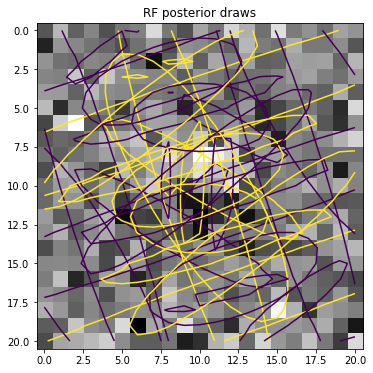

In [4]:
contour_draws(g.prior, g, obs_stats, d=21)

In [ ]:
# network architecture: 8 layer network [4x conv, 3x fully conn., 1x MoG], 20k parameters in total 

filter_sizes=[3,3,3,2]   # 4 conv ReLU layers
n_filters=(16,16,32,32)  # 16 to 32 filters
pool_sizes=[1,2,2,1]     # 
n_hiddens=[50,50,50]     # 3 fully connected layers

# N = 100k per round

n_train=10000

# single component (posterior at most STAs is well-approximated by single Gaussian - we also want to run more SNPE-A)

n_components=2

# single rounds (first round is always'amortized' and can be used with any other STA covered by the prior)

n_rounds=2

# new feature for CNN architectures: passing a value directly to the hidden layers (bypassing the conv layers).
# In this case, we pass the number of spikes (single number) directly, which allows to normalize the STAs 
# and hence help out the conv layers. Without that extra input, we couldn't recover the RF gain anymore. 
n_inputs_hidden = 1

# some learning-schedule parameters
lr_decay = 0.99
epochs=50
minibatch=50

svi=False          # large N should make this do nothing anyways
reg_lambda=0.      # just to make doubly sure SVI is switched off...

pilot_samples=1000 # z-scoring only applies to extra inputs (here: firing rate) directly fed to fully connected layers

prior_norm = True  # doesn't hurt. 
init_norm = False  # didn't yet figure how to best normalize initialization through conv- and ReLU- layers

inf = infer.CDELFI(generator=g, obs=obs_stats, prior_norm=prior_norm, init_norm=init_norm,
                 pilot_samples=pilot_samples, seed=seed, reg_lambda=reg_lambda, svi=svi,
                 n_components=1, n_hiddens=n_hiddens, n_filters=n_filters, n_inputs = (1,d,d),
                 filter_sizes=filter_sizes, pool_sizes=pool_sizes, n_inputs_hidden=n_inputs_hidden)

# print parameter numbers per layer (just weights, not biases)
def get_shape(i):
    return inf.network.aps[i].get_value().shape
print([get_shape(i) for i in range(1,17,2)])
print([np.prod(get_shape(i)) for i in range(1,17,2)])

# run SNPE-A for one round
log, trn_data, posteriors = inf.run(n_train=n_train, epochs=epochs, minibatch=minibatch, n_rounds=n_rounds,  
               lr_decay=lr_decay, n_components=n_components)


In [ ]:
posterior = posteriors[-1] 
posterior.ndim = posterior.xs[0].ndim

quick_plot(g, obs_stats, d, pars_true, posterior, log)

# all pairwise marginals of fitted posterior
fig, _ = plot_pdf(posterior, pdf2=g.prior, lims=[-3,3], gt=pars_true.reshape(-1), figsize=(16,16), resolution=100,
                  labels_params=['bias', 'log gain', 'logit phase', 'log freq', 'logit angle', 'log ratio', 'log width'])
fig.savefig('res.pdf')

# bunch of example posterior draw contours
contour_draws(posterior, g, obs_stats, d)

# test toy cells (check for 'amortization')

# 0.5 Hz, SNR -15

In [ ]:
a,b = 0.504180511342426, -0.8202461745687 # gain and phase together define firing rate and SNR

for j in range(3):
    
    print('\n')
    print('cell #' + str(j+1))
    print('\n')
    
    params_dict_test = np.load('./results/toy_cells/toy_cell_' + str(j+1) + '.npy')[()]
    
    m.params_dict = params_dict_test.copy()
    
    params_dict_test['kernel']['gain'] = a
    params_dict_test['glm']['bias'] = b
    
    pars_test = m.read_params_buffer()
    stats = s.calc([m.gen_single(pars_test)])

    post_test = inf.predict_uncorrected(s.calc([m.gen_single(pars_test)]))

    fig, _ = plot_pdf(post_test, pdf2=p, lims=[-3,3], gt=pars_test.reshape(-1), figsize=(12,12), resolution=100,
                  labels_params=['bias', 'log gain', 'logit phase', 'log freq', 'logit angle', 'log ratio', 'log width'])


    plt.figure(figsize=(6,6))
    plt.subplot(2,3,1)
    plt.imshow(m.params_to_rf(pars_test)[0], interpolation='None')
    plt.subplot(2,3,2)
    plt.imshow(m.params_to_rf(post_test.xs[0].m.reshape(-1))[0], interpolation='None')
    plt.subplot(2,3,3)
    plt.imshow(stats[0,:-1].reshape(d,d), interpolation='None')
    
    for i in range(8):
        plt.subplot(4,4,9+i)
        plt.imshow(m.params_to_rf(post_test.gen().reshape(-1))[0], interpolation='None')

    plt.show()


# 2 Hz, SNR -15

In [ ]:
a,b = 0.422120643630379, 0.604054261670482 # gain and phase together define firing rate and SNR

for j in range(3):
    
    print('\n')
    print('cell #' + str(j+1))
    print('\n')
    
    params_dict_test = np.load('./results/toy_cells/toy_cell_' + str(j+1) + '.npy')[()]
    
    m.params_dict = params_dict_test.copy()
    
    params_dict_test['kernel']['gain'] = a
    params_dict_test['glm']['bias'] = b
    
    pars_test = m.read_params_buffer()
    stats = s.calc([m.gen_single(pars_test)])

    post_test = inf.predict_uncorrected(s.calc([m.gen_single(pars_test)]))

    fig, _ = plot_pdf(post_test, pdf2=p, lims=[-3,3], gt=pars_test.reshape(-1), figsize=(12,12), resolution=100,
                  labels_params=['bias', 'log gain', 'logit phase', 'log freq', 'logit angle', 'log ratio', 'log width'])


    plt.figure(figsize=(6,6))
    plt.subplot(2,3,1)
    plt.imshow(m.params_to_rf(pars_test)[0], interpolation='None')
    plt.subplot(2,3,2)
    plt.imshow(m.params_to_rf(post_test.xs[0].m.reshape(-1))[0], interpolation='None')
    plt.subplot(2,3,3)
    plt.imshow(stats[0,:-1].reshape(d,d), interpolation='None')
    
    for i in range(8):
        plt.subplot(4,4,9+i)
        plt.imshow(m.params_to_rf(post_test.gen().reshape(-1))[0], interpolation='None')


    plt.show()


# 5 Hz, SNR -15

In [ ]:
a,b = 0.357703095858336, 1.54546216004078 # gain and phase together define firing rate and SNR

for j in range(3):
    
    print('\n')
    print('cell #' + str(j+1))
    print('\n')
    
    params_dict_test = np.load('./results/toy_cells/toy_cell_' + str(j+1) + '.npy')[()]
    
    m.params_dict = params_dict_test.copy()
    
    params_dict_test['kernel']['gain'] = a
    params_dict_test['glm']['bias'] = b
    
    pars_test = m.read_params_buffer()
    stats = s.calc([m.gen_single(pars_test)])

    post_test = inf.predict_uncorrected(s.calc([m.gen_single(pars_test)]))

    fig, _ = plot_pdf(post_test, pdf2=p, lims=[-3,3], gt=pars_test.reshape(-1), figsize=(12,12), resolution=100,
                  labels_params=['bias', 'log gain', 'logit phase', 'log freq', 'logit angle', 'log ratio', 'log width'])


    plt.figure(figsize=(6,6))
    plt.subplot(2,3,1)
    plt.imshow(m.params_to_rf(pars_test)[0], interpolation='None')
    plt.subplot(2,3,2)
    plt.imshow(m.params_to_rf(post_test.xs[0].m.reshape(-1))[0], interpolation='None')
    plt.subplot(2,3,3)
    plt.imshow(stats[0,:-1].reshape(d,d), interpolation='None')
    
    for i in range(8):
        plt.subplot(4,4,9+i)
        plt.imshow(m.params_to_rf(post_test.gen().reshape(-1))[0], interpolation='None')


    plt.show()


# 1 Hz , SNR $\sim$ 1/8

In [ ]:
a,b = 0.852551611364445, -0.363422125020056 # gain and phase together define firing rate and SNR

for j in range(3):
    
    print('\n')
    print('cell #' + str(j+1))
    print('\n')
    
    params_dict_test = np.load('./results/toy_cells/toy_cell_' + str(j+1) + '.npy')[()]
    
    m.params_dict = params_dict_test.copy()
    
    params_dict_test['kernel']['gain'] = a
    params_dict_test['glm']['bias'] = b
    
    pars_test = m.read_params_buffer()
    stats = s.calc([m.gen_single(pars_test)])

    post_test = inf.predict_uncorrected(s.calc([m.gen_single(pars_test)]))

    fig, _ = plot_pdf(post_test, pdf2=p, lims=[-3,3], gt=pars_test.reshape(-1), figsize=(12,12), resolution=100,
                  labels_params=['bias', 'log gain', 'logit phase', 'log freq', 'logit angle', 'log ratio', 'log width'])


    plt.figure(figsize=(6,6))
    plt.subplot(2,3,1)
    plt.imshow(m.params_to_rf(pars_test)[0], interpolation='None')
    plt.subplot(2,3,2)
    plt.imshow(m.params_to_rf(post_test.xs[0].m.reshape(-1))[0], interpolation='None')
    plt.subplot(2,3,3)
    plt.imshow(stats[0,:-1].reshape(d,d), interpolation='None')
    
    for i in range(8):
        plt.subplot(4,4,9+i)
        plt.imshow(m.params_to_rf(post_test.gen().reshape(-1))[0], interpolation='None')


    plt.show()


# save & load

In [ ]:
import delfi.utils.io as io

try: 
    inf.observables
except:
    inf.observables = []

filename1 = './results/SNPE/maprf_100k_amortized_prior01_run_1_round1_param7_nosvi_base.pkl'
filename2 = './results/SNPE/maprf_100k_amortized_prior01_run_1_round1_param7_nosvi_base_res.pkl'
filename3 = './results/SNPE/maprf_100k_amortized_prior01_run_1_round1_param7_nosvi_base_conf.pkl'
filename4 = './results/SNPE/maprf_100k_amortized_prior01_run_1_round1_param7_nosvi_base_net_only.pkl'

io.save_pkl((log, trn_data, posterior),filename1)
np.save(filename3, params_dict_true)
io.save_pkl(inf.network, filename4)
inf.generator.model = None
io.save(inf, filename2)


In [ ]:
T = np.load('posterior_samples_20.npz')['arr_0'].tolist()['T']
samples = np.hstack([np.atleast_2d(T[key].T).T for key in ['log_A', 'logit_φ', 'log_f','logit_θ','log_γ','log_b']])

plot_pdf(posterior, pdf2=p, lims=[-3,3], gt=pars_true.reshape(-1), figsize=(16,16), resolution=100, samples=samples.T,
         ticks=True, labels_params=['log gain', 'logit phase', 'log freq', 'logit angle', 'log ratio', 'log width']);


# check prior

In [ ]:
T = np.load('prior_samples.npz')['arr_0'].tolist()['T']
samples = np.hstack([np.atleast_2d(T[key].T).T for key in ['log_A', 'logit_φ', 'log_f','logit_θ','log_γ','log_b']])

plot_pdf(p, lims=[-3,3], gt=pars_true.reshape(-1), figsize=(16,16), resolution=100, samples=samples.T,
         ticks=True, labels_params=['log_A', 'logit_φ', 'log_f', 'logit_θ', 'log ratio', 'log width']);


T = np.load('prior_samples.npz')['arr_0'].tolist()['T']
samples = np.hstack([np.atleast_2d(T[key].T).T for key in ['gain', 'phase', 'freq','angle','ratio','width']])

ks = params_dict_true['kernel']['s']
pars_raw = np.array([ ks['gain'], ks['phase'], ks['freq'], ks['angle'], ks['ratio'], ks['width'] ])

plot_pdf(p, lims=[-3,3], gt=pars_raw.reshape(-1), figsize=(16,16), resolution=100, samples=samples.T,
         ticks=True, labels_params=['gain', 'phase', 'freq', 'angle', 'ratio', 'width']);


# compare with maprf sampling

In [ ]:
import numpy as np
import numpy.random as nr
import maprf.config as config
import maprf.rfs.v1 as V1
import maprf.invlink as invlink
import maprf.glm as glm 
from maprf.utils import *
from maprf.data import SymbolicData
import time
import maprf.filters as filters
import maprf.kernels as kernels
# from maprf.sampling.slice import EllipticalSliceSampler as ESS

import theano.printing as printing
import theano.tensor as tt

import theano
from theano import In

import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from os import path
from maprf.inference import *

def pyprint(var, filename):
    printing.pydotprint(var, format='pdf', outfile=filename, high_contrast=False, with_ids=True)

cfg = config.load(path.join('config.yaml'))

# The forward part of the model
rf = V1.SimpleLinear_full_kt()
emt = glm.Poisson()
# inputs and outputs
data = [theano.shared(empty(3), 'frames'),
        theano.shared(empty(1, dtype='int64'))]
frames, spikes = data

# fill the grids
rf.grids['s'][0].set_value(m._gen.grid_x)
rf.grids['s'][1].set_value(m._gen.grid_y)
rf.grids['t'][0].set_value(m._gen.axis_t)

# inference model
inference = Inference(rf, emt, bias=params_dict_true['glm']['bias'])
inference.priors = {
    #'glm': {         'bias':  {'name':  'gamma',
    #                           'varname': 'λo',
    #                           'alpha': 1.0, #prior['λo']['alpha'][0],
    #                           'beta':  1.0}}, #prior['λo']['beta'][0]}},
    'kernel': {'s': {'ratio':  {'name': 'normal',
                                'varname': 'log_γ',
                                'sigma': prior['log_γ']['sigma'][0],
                                'mu':    prior['log_γ']['mu'][0]}, 
                     'width':  {'name': 'normal',
                                'varname': 'log_b',
                                'sigma': prior['log_b']['sigma'][0],
                                'mu':    prior['log_b']['mu'][0]}}}}        
if 'vec_A' in prior.keys():
    inference.priors['kernel']['s']['phase'] =   {'name': 'Rayleigh',
                                                  'varname': 'vec_A',
                                                  'sigma': prior['vec_A']['sigma'][0]}            
elif 'log_A' in prior.keys() and 'logit_φ' in prior.keys():
    inference.priors['kernel']['s']['gain'] =  {'name': 'lognormal',
                                                  'varname': 'log_A',
                                                  'mu': prior['log_A']['mu'][0],
                                                  'sigma': prior['log_A']['sigma'][0]}            
    inference.priors['kernel']['s']['phase'] =  {'name': 'logitnormal',
                                                  'varname': 'logit_φ',
                                                  'mu': prior['logit_φ']['mu'][0],
                                                  'sigma': prior['logit_φ']['sigma'][0]}            
elif 'float_A' in prior.keys() and 'logit_φ' in prior.keys():
    inference.priors['kernel']['s']['gain'] =  {'name': 'normal',
                                                  'varname': 'float_A',
                                                  'mu': prior['float_A']['mu'][0],
                                                  'sigma': prior['float_A']['sigma'][0]}            
    inference.priors['kernel']['s']['phase'] =  {'name': 'logitnormal',
                                                  'varname': 'logit_φ',
                                                  'mu': prior['logit_φ']['mu'][0],
                                                  'sigma': prior['logit_φ']['sigma'][0]}      
else:
    raise NotImplemented()
    
    
if 'vec_f' in prior.keys():
    inference.priors['kernel']['s']['freq'] =   {'name': 'Rayleigh',
                                                 'varname': 'vec_f',
                                                 'sigma': prior['vec_f']['sigma'][0]}        
elif 'log_f' in prior.keys() and 'logit_θ' in prior.keys():
    inference.priors['kernel']['s']['freq'] =  {'name': 'lognormal',
                                                  'varname': 'log_f',
                                                  'mu': prior['log_f']['mu'][0],
                                                  'sigma': prior['log_f']['sigma'][0]}            
    inference.priors['kernel']['s']['angle'] =  {'name': 'logitnormal',
                                                  'varname': 'logit_θ',
                                                  'mu': prior['logit_θ']['mu'][0],
                                                  'sigma': prior['logit_θ']['sigma'][0]}            
else:
    raise NotImplemented()


if 'kt' in prior.keys():
    inference.priors['kernel']['t'] = prior['kt']


inference.add_sampler(GaborSampler(fix_position=True, parametrization='logit_φ'))
print(inference.samplers[0].params)

#inference.add_sampler(KernelSampler())
kt = tt.vector('kt')
inference.rf.filter.kernel['t'] = kt / tt.sqrt(tt.dot(kt, kt))
#inference.add_update(kt, kt)
inference.add_inputs(kt)

print('inputs: ', inference.inputs)
print('priors: ', inference.priors)

inference.build(data)
inference.compile()


inference.loglik['xo'] = 0.
inference.loglik['yo'] = 0.
#inference.loglik['logit_φ'] = 0.0  # np.array([2.0, 0.0])
ks = params_dict_true['kernel']['s']
log_γ = np.log(ks['ratio'])
log_b = np.log(ks['width'])
inference.loglik['log_γ'] = log_γ  # 0.
inference.loglik['log_b'] = log_b # np.log(2.5)
inference.loglik['kt'] =    params_dict_true['kernel']['t']['value'].copy()  # np.array([0.5, 0.0])

if 'vec_A' in prior.keys():
    vec_A = m.pol2cart(np.atleast_2d([ks['gain'], ks['phase']])).reshape(-1)
    inference.loglik['vec_A'] = vec_A  # np.zeros(2)  # 0.3 * np.array([np.cos(0.7), np.sin(0.7)])
elif 'log_A' in prior.keys() and 'logit_φ' in prior.keys():
    log_A, logit_φ = np.log(ks['gain']), ks['phase']
    inference.loglik['log_A'] = log_A  # np.zeros(2)  # 0.3 * np.array([np.cos(0.7), np.sin(0.7)])
    inference.loglik['logit_φ'] = logit_φ  # np.zeros(2)  # 0.3 * np.array([np.cos(0.7), np.sin(0.7)])
elif 'float_A' in prior.keys() and 'logit_φ' in prior.keys():
    float_A, logit_φ = ks['gain'], np.log(ks['phase'] / (np.pi/2. - ks['phase']))
    inference.loglik['float_A'] = float_A  # np.zeros(2)  # 0.3 * np.array([np.cos(0.7), np.sin(0.7)])
    inference.loglik['logit_φ'] = logit_φ  # np.zeros(2)  # 0.3 * np.array([np.cos(0.7), np.sin(0.7)])

if 'vec_f' in prior.keys():
    vec_f = m.pol2cart(np.atleast_2d([ks['freq'], ks['angle']])).reshape(-1)    
    inference.loglik['vec_f'] = vec_f 
elif 'log_f' in prior.keys() and 'logit_θ' in prior.keys():
    log_f, logit_θ = np.log(ks['freq']), np.log(ks['angle'] / (2*np.pi - ks['angle']))
    inference.loglik['log_f'] = log_f  
    inference.loglik['logit_θ'] = logit_θ  
    
frames.set_value(obs['I'][:,:].reshape(-1,d,d))
spikes.set_value(obs['data'][:])

#frames.set_value(0*obs['I'][:1,:].reshape(-1,d,d))
#spikes.set_value(0*obs['data'][:1])

plt.plot(spikes.get_value())

print(np.sum(obs['data']))

In [ ]:

import datetime

T, L = inference.sample(100000)
T = {k.name: t for k, t in T.items()}

x = T['xo']
y = T['yo']

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(x[500:])

plt.subplot(122)
plt.hist(x[500:], alpha=0.5, normed=True)
plt.show()

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(x[500:], y[500:], '.k', alpha=0.1)
plt.show()


In [ ]:

for t in np.sort(np.random.choice(T['gain'].shape[0], 100, replace=False)):
    params_dict = {'kernel' : {'s' : {}}, 'glm': {}}
    #params_dict['glm']['bias'] = T['bias'][t]
    params_dict['kernel']['s']['phase'] = T['phase'][t]
    params_dict['kernel']['s']['angle'] = T['angle'][t] 
    params_dict['kernel']['s']['freq']  = T['freq'][t]
    params_dict['kernel']['s']['ratio'] = T['ratio'][t]
    params_dict['kernel']['s']['width'] = T['width'][t]
    params_dict['kernel']['s']['gain'] = T['gain'][t]

    ks = m._eval_ks(bias=-0.5, 
                             angle=params_dict['kernel']['s']['angle'],
                             freq=params_dict['kernel']['s']['freq'],
                             gain=params_dict['kernel']['s']['gain'],
                             phase=params_dict['kernel']['s']['phase'],
                             ratio=params_dict['kernel']['s']['ratio'],
                             width=params_dict['kernel']['s']['width'])

    plt.imshow(np.hstack((ks.reshape(d,d), m.params_to_rf(pars_true)[0])), interpolation='None')
    plt.title('t =' + str(t))
    plt.show()

    print('loc:' , [T['xo'][t], T['yo'][t]])

In [ ]:
x=T['ratio'][50:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('ratio')
plt.show()
print('mean:', T['ratio'].mean())
print('var:', T['ratio'].var())

x=T['log_γ'][50:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('log ratio')
plt.show()
print('mean:', T['log_γ'].mean())
print('var:', T['log_γ'].var())

x=T['width'][50:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('width')
plt.show()
print('mean:', T['width'].mean())
print('var:', T['width'].var())

x=T['log_b'][50:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('log width')
plt.show()
print('mean:', T['log_b'].mean())
print('var:', T['log_b'].var())


x=T['angle'][50:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('angle')
plt.show()
print('mean:', T['angle'].mean())
print('var:', T['angle'].var())

x=T['freq'][50:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('freq')
plt.show()
print('mean:', T['freq'].mean())
print('var:', T['freq'].var())

if 'vec_f' in T.keys():
    x=T['vec_f'][50:,0]
    plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
    plt.title('vec_f[0]')
    plt.show()
    print('mean:', T['vec_f'][:,0].mean())
    print('var:',  T['vec_f'][:,0].var())

    x=T['vec_f'][50:,1]
    plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
    plt.title('vec_f[1]')
    plt.show()
    print('mean:', T['vec_f'][:,1].mean())
    print('var:',  T['vec_f'][:,1].var())

x=T['gain'][500:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('gain')
plt.show()
print('mean:', T['gain'].mean())
print('var:', T['gain'].var())

x=T['phase'][50:]
plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
plt.title('phase')
plt.show()
print('mean:', T['phase'].mean())
print('var:', T['phase'].var())

if 'logit_φ' in T.keys():
    x=T['logit_φ'][50:]
    plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
    plt.title('logit phase')
    plt.show()
    print('mean:', T['logit_φ'].mean())
    print('var:', T['logit_φ'].var())

if 'log_A' in T.keys():
    x=T['log_A'][50:]
    plt.hist(x, bins=np.linspace(x.min(), x.max(), 50), alpha=0.5, normed=True)
    plt.title('log_A')
    plt.show()
    print('mean:', T['log_A'][:].mean())
    print('var:',  T['log_A'][:].var())
    

if 'vec_A' in T.keys():
    x=T['vec_A'][50:,0]
    plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
    plt.title('vec_A[0]')
    plt.show()
    print('mean:', T['vec_A'][:,0].mean())
    print('var:',  T['vec_A'][:,0].var())    
    x=T['vec_A'][50:,1]
    plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
    plt.title('vec_A[1]')
    plt.show()
    print('mean:', T['vec_A'][:,1].mean())
    print('var:',  T['vec_A'][:,1].var())
    
if 'bias' in T.keys():
    x=T['bias'][50:]
    plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
    plt.title('bias')
    plt.show()
    print('mean:', T['bias'].mean())
    print('var:', T['bias'].var())

if 'λo' in T.keys():
    x=T['λo'][50:]
    plt.hist(x, bins=np.linspace(x.min(), x.max(), 20), alpha=0.5, normed=True)
    plt.title('exp bias')
    plt.show()
    print('mean:', T['λo'].mean())
    print('var:', T['λo'].var())


In [ ]:
#T = np.load('posterior_samples_20.npz')['arr_0'].tolist()['T']
samples = np.hstack([np.atleast_2d(T[key].T).T for key in ['log_A', 'logit_φ', 'log_f','logit_θ','log_γ','log_b']])

plot_pdf(p, lims=[-3,3], gt=pars_true.reshape(-1), figsize=(16,16), resolution=100, samples=samples.T,
         ticks=True, labels_params=['log gain', 'logit phase', 'log freq', 'logit angle', 'log ratio', 'log width']);


In [ ]:
plt.plot(samples)
plt.show()

In [ ]:
try: 
    np.savez('posterior_samples_20', {'T' : T})
except:
    pass

In [ ]:
#try: 
#    np.savez('prior_samples', {'T' : T})
#except:
#    pass